#### Задача
Реализуйте генерацию случайного графа в модели Барабаши--Альберт, конкретизованной следующим образом:

В каждый момент времени добавляем одну вершину и $m$ ребер.

Начинаем с вершины 0 без ребер, но с весом, равным $m$. 

Вершина 1 ставит $m$ ссылок на 0. Вес вершины 0 становится $2m$, вес вершины 1 становится $m$.

Дальнейшие вершины ставят $m$ ссылок независимо, каждую с вероятностью, пропорциональной весам существующих вершин (равным сумме их входящих степеней и $m$):
$$
P(n+1\to i)=\frac{\mathrm{indeg}\,i + m}{\sum\limits_{k=0}^n(\mathrm{indeg}\,k + m)}=\frac{\mathrm{indeg}\,i + m}{2mn + m}.
$$
Используя теорему Авраченкова, при фиксированном $n$ постройте оценку для кумулятивной функции распределения пейджранка $P(\pi_v > x)$. Сгенерируйте граф на $n=1000$ вершинах при $m=5$ и постройте на одном графике данную оценку и соответствующее распределение пейджранка для полученного графа при $c=0.85$.

In [232]:
import networkx as nx
import matplotlib.pyplot as plt
import pylab
# Рисуем графики не создавая новых окон
%matplotlib inline

In [282]:
import random
def generateGraph(n, m):
    G = nx.MultiDiGraph()
    G.add_node(0)
    G.add_node(1)
    for x in xrange(m):
        G.add_edge(1, 0)
    repeated_nodes = [0] * (2 * m) + [1] * m
    while G.number_of_nodes() <= n:
        new_node = G.number_of_nodes()
        G.add_node(new_node)
        # выбираем конец ребра пропорционально входящей степени вершины + m
        dests = []
        for x in xrange(m):
            destination = random.choice(repeated_nodes)
            G.add_edge(new_node, destination)
            dests.append(destination)
        repeated_nodes.extend(dests)
        repeated_nodes.extend([new_node] * m)
    return G

In [288]:
N = 1000
m = 5
G = generateGraph(N, m)
# петля (0, 0) для того, чтобы не учитывать вершины нулевой степени
G.add_edge(0, 0)

In [289]:
c = 0.85
P = nx.pagerank_scipy(G, c)

In [290]:
pagerank_distr = []
xs = []
for x in sorted(P.values()):
    xs.append(x)
    pagerank_distr.append(len([v for v in G.nodes() if P[v] >= x]) / float(N))

Согласно теореме Авраченкова, при $ i > 0 $ среднее значение пейджранка вершины $i$:
$$
{\bf E}\pi_i(n) 
\approx \frac{1-c}{1+n}\left(\frac{1}{1+c} + \frac{c}{1+c}\left(i+\frac{1}{2}\right)^{-\frac{1+c}{2}} \left(n+\frac{1}{2}\right)^{\frac{1+c}{2}}\right).
$$

Тогда при фиксированном $n$: ${\bf E}\pi_i=f(i)$, где $f(i)$ - убывающая функция. Поэтому,
\begin{equation*}
\begin{split}
\textbf{P}(\pi_i<x)&=\textbf{P}(i>f^{-1}(x))\approx\textbf{P}\left(i>\left(\left(\frac{1+n}{1-c}x-\frac{1}{1+c}\right)\frac{1+c}{c}\left(n+\frac{1}{2}\right)^{-\frac{1+c}{2}}\right)^{\frac{-2}{1+c}}-\frac12\right)=\\
&=1-\frac{1}{n}\cdot\left(\left(\left(\frac{1+n}{1-c}x-\frac{1}{1+c}\right)\frac{1+c}{c}\left(n+\frac{1}{2}\right)^{-\frac{1+c}{2}}\right)^{\frac{-2}{1+c}}-\frac12\right)=\\
&=1+\frac{1}{2n}-\left(1+\frac{1}{2n}\right)c^{\frac{2}{c+1}}\left(\frac{1+c}{1-c}(n+1)x-1\right)^{\frac{-2}{1+c}}.
\end{split}
\end{equation*}

При этом $\textbf{P}(\pi_i>=x)=1-\textbf{P}(\pi_i<x)$. Построим по данной формуле оценку для вероятностей соответствующих значений пейджранка вершин:

In [297]:
theoretical_est = []
xs2 = []
for x in np.arange(min(P.values()), max(P.values()), 0.001):
    val = (1 + 1.0 / (2 * N)) * c ** (2. / (c + 1))
    val *= ((N + 1) * (1 + c) * x / (1 - c) - 1) ** (-2. / (c + 1))
    val = 1 + 1.0 / (2 * N) - val
    xs2.append(x)
    theoretical_est.append(1 - val)

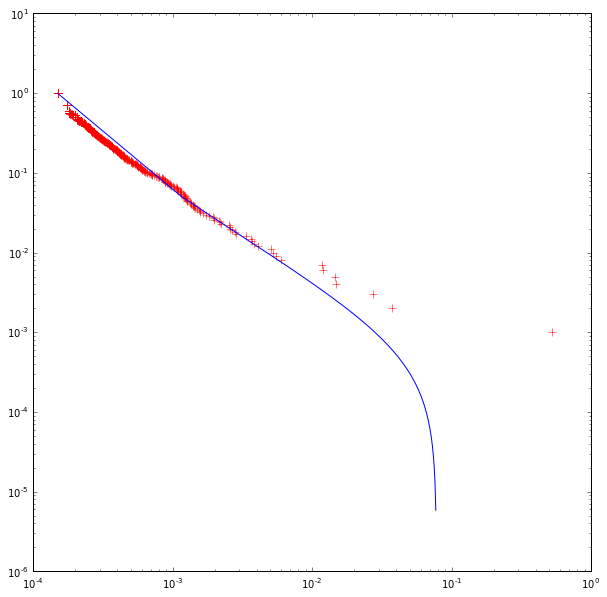

In [298]:
import matplotlib.pyplot as plt

pylab.rcParams['figure.figsize'] = 10, 10
plt.loglog(xs, pagerank_distr, c='r', marker='+', ls='None', markersize=8)
plt.loglog(xs2, theoretical_est)
plt.show()